# Model Evaluation

## Pipeline and Feature Unions
It is always a good decision to make your code as readable as possible.  Not only so that others can pick it up and use it easily, but so that you don't end up hating your past self when you take a look at something you wrote several months prior.  Pipelines are a great tool for integrating and reusing a series of data transformations and fits into a workflow. In this exercise you'll build some pipelines and feature unions using the Concrete Compressive Data Set.

1 - Head over to the [Machine Learning Repository](http://archive.ics.uci.edu/ml/index.php), download the [Concrete Compressive Data Set](http://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/), put it into a dataframe, and split into training and test sets.  Be sure to familiarize yourself with the data before proceeding.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import resample
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import f_regression, SelectKBest, SelectFromModel
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, GridSearchCV,\
                                    learning_curve, StratifiedKFold, LeaveOneOut, KFold
from sklearn.metrics import mean_squared_error, confusion_matrix, precision_score, accuracy_score, recall_score,\
                            f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LinearRegression, LassoCV, LogisticRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [17]:
concrete = pd.read_excel('http://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls')
concrete.columns = ['cement', 'blast_furnace_slag', 'fly_ash', 'water', 'superplasticizer',
                    'coarse_aggregate', 'fine_aggregate', 'age', 'concrete_compressive_strength']

In [3]:
concrete.head()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,concrete_compressive_strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [4]:
concrete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
cement                           1030 non-null float64
blast_furnace_slag               1030 non-null float64
fly_ash                          1030 non-null float64
water                            1030 non-null float64
superplasticizer                 1030 non-null float64
coarse_aggregate                 1030 non-null float64
fine_aggregate                   1030 non-null float64
age                              1030 non-null int64
concrete_compressive_strength    1030 non-null float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [5]:
concrete.describe().T

,count,mean,std,min,25%,50%,75%,max
cement,1030.0,281.165631,104.507142,102.000000,192.375000,272.900000,350.000000,540.000000
blast_furnace_slag,1030.0,73.895485,86.279104,0.000000,0.000000,22.000000,142.950000,359.400000
fly_ash,1030.0,54.187136,63.996469,0.000000,0.000000,0.000000,118.270000,200.100000
water,1030.0,181.566359,21.355567,121.750000,164.900000,185.000000,192.000000,247.000000
superplasticizer,1030.0,6.203112,5.973492,0.000000,0.000000,6.350000,10.160000,32.200000
coarse_aggregate,1030.0,972.918592,77.753818,801.000000,932.000000,968.000000,1029.400000,1145.000000
fine_aggregate,1030.0,773.578883,80.175427,594.000000,730.950000,779.510000,824.000000,992.600000
age,1030.0,45.662136,63.169912,1.000000,7.000000,28.000000,56.000000,365.000000
concrete_compressive_strength,1030.0,35.817836,16.705679,2.331808,23.707115,34.442774,46.136287,82.599225


In [18]:
Xtrain, Xtest, ytrain, ytest = train_test_split(concrete.drop('concrete_compressive_strength', axis=1),
                                                concrete.concrete_compressive_strength, 
                                                test_size=0.2, random_state=42)

2 - Build a pipeline for polynomial fitting, fit polynomials of degree 1 to the number of features, and plot your training and testing errors for each.  Comment on your results

In [19]:
# scaling+pol+linear regression
pipe = Pipeline([
    ('scl', StandardScaler()),
    ('poly', PolynomialFeatures()),
    ('lr', LinearRegression())
])

In [22]:
scores = []
# looping through degrees
for n in range(1, Xtrain.shape[1]+1):
    # set pipeline params
    pipe.set_params(poly__degree=n)
    # fit and score
    pipe.fit(Xtrain, ytrain)
    scores.append([n, pipe.score(Xtrain, ytrain), pipe.score(Xtest, ytest),
                   mean_squared_error(pipe.predict(Xtrain), ytrain), mean_squared_error(pipe.predict(Xtest), ytest)])

scores = pd.DataFrame(scores)
scores.columns = ['degree', 'train score', 'test score', 'train mse', 'test mse']

In [23]:
scores

,degree,train score,test score,train mse,test mse
0,1,0.610459,6.275416e-01,110.661771,9.597548e+01
1,2,0.813116,7.842685e-01,53.090518,5.558993e+01
2,3,0.931086,8.437174e-01,19.577340,4.027107e+01
3,4,0.983277,-2.352121e+01,4.750605,6.318652e+03
4,5,0.993065,-8.443128e+16,1.970058,2.175634e+19
5,6,0.997491,-4.868762e+10,0.712772,1.254588e+13
6,7,0.997542,-2.671983e+10,0.698360,6.885195e+12
7,8,0.997542,-2.194118e+10,0.698360,5.653827e+12


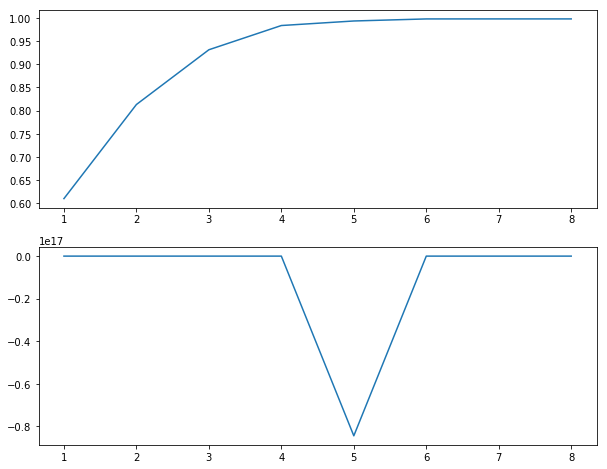

In [19]:
# plot on two separate axes cause the scales are very different
fig, ax = plt.subplots(2, figsize=(10, 8))
ax[0].plot(scores.degree, scores['train score'], label='train score')
ax[1].plot(scores.degree, scores['test score'], label='test score');

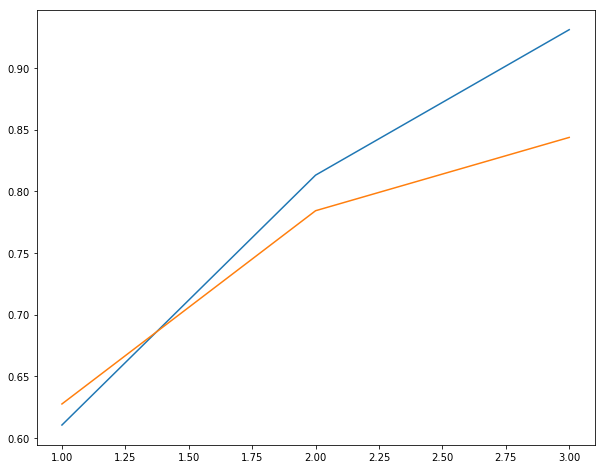

In [25]:
# single plot for n=1,2,3
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(scores.iloc[:3, 0], scores.iloc[:3, 1], label='train score')
ax.plot(scores.iloc[:3, 0], scores.iloc[:3, 2], label='test score');

Increasing the number of features increases the training score but we get very bad generalization (with a really strange peak for the fifth degree polynomial). The best score is for the third degree (84%).

3 - Build a pipeline that will perform feature selection on the dataset using the F-Statistic, producing the same plots as in part (2).  Comment on your results.

In [26]:
# scaling, select k best and linear regression
pipe = Pipeline([
    ('scl', StandardScaler()),
    ('best', SelectKBest(f_regression)),
    ('lr', LinearRegression())
])

In [28]:
scores = []
# looping over number of features
for n in range(1, Xtrain.shape[1]+1):
    # set pipe params
    pipe.set_params(best__k=n)
    # fit and score
    pipe.fit(Xtrain, ytrain)
    scores.append([n, pipe.score(Xtrain, ytrain), pipe.score(Xtest, ytest),
                   mean_squared_error(pipe.predict(Xtrain), ytrain), mean_squared_error(pipe.predict(Xtest), ytest)])

scores = pd.DataFrame(scores)
scores.columns = ['n_features', 'train score', 'test score', 'train mse', 'test mse']

In [29]:
scores

,n_features,train score,test score,train mse,test mse
0,1,0.246699,0.251831,213.999800,192.788897
1,2,0.346373,0.371407,185.684137,161.976448
2,3,0.469642,0.533248,150.665682,120.273091
3,4,0.485188,0.556152,146.249264,114.371259
4,5,0.495800,0.550043,143.234484,115.945336
5,6,0.555148,0.634291,126.374789,94.236333
6,7,0.594330,0.598502,115.243705,103.458495
7,8,0.610459,0.627542,110.661771,95.975484


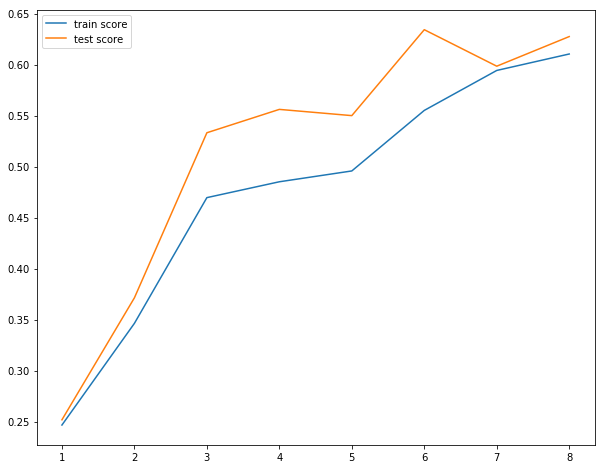

In [30]:
# train and test on a single plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(scores.n_features, scores['train score'], label='train score')
ax.plot(scores.n_features, scores['test score'], label='test score')
ax.legend();

After adding the sixth variable we have little improvement in the results.

4 - Build a pipeline that standardizes your data, performs feature selection via regularization, and then fits a model of your choice.  Produce the same plots as above and comment on your results.

In [37]:
# scaling, select from model using lassoCV and lassoCV
pipe = Pipeline([
    ('scl', StandardScaler()),
    ('sfmod', SelectFromModel(LassoCV())),
    # ('lasso', LassoCV())
    ('forest', RandomForestRegressor()) # used in solution
])

In [38]:
scores = []
# looping through threshold values
for c in np.arange(0.1, 2.1, 0.1):
    pipe.set_params(sfmod__threshold=str(c) + '*mean')
    pipe.fit(Xtrain, ytrain)
    scores.append([c, pipe.score(Xtrain, ytrain), pipe.score(Xtest, ytest),
                   mean_squared_error(pipe.predict(Xtrain), ytrain), mean_squared_error(pipe.predict(Xtest), ytest)])
#     sel = pipe.named_steps['sfmod']
#     print(Xtrain.columns[sel.transform(np.arange(len(Xtrain.columns)).reshape(1, -1))])

scores = pd.DataFrame(scores)
scores.columns = ['threshold', 'train score', 'test score', 'train mse', 'test mse']

In [39]:
scores

,threshold,train score,test score,train mse,test mse
0,0.1,0.982412,0.866411,4.996542,34.423295
1,0.2,0.980343,0.858554,5.584130,36.447952
2,0.3,0.981444,0.851837,5.271501,38.178921
3,0.4,0.979916,0.847017,5.705384,39.420932
4,0.5,0.979708,0.846753,5.764719,39.488738
5,0.6,0.965539,0.822644,9.789734,45.701326
6,0.7,0.967667,0.849198,9.185124,38.858850
7,0.8,0.964817,0.835547,9.994747,42.376311
8,0.9,0.969069,0.833785,8.786909,42.830404
9,1.0,0.963735,0.765613,10.302199,60.397106


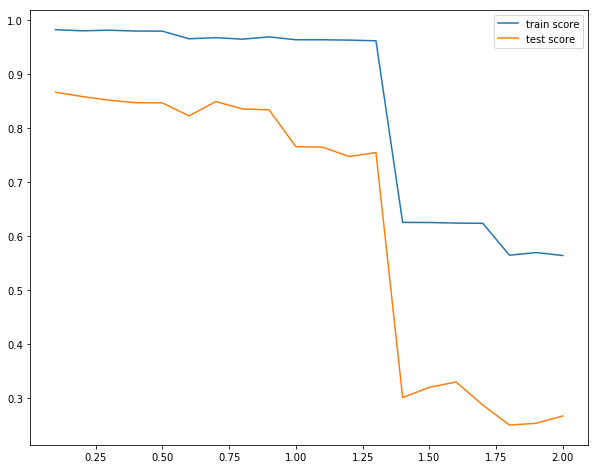

In [40]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(scores.threshold, scores['train score'], label='train score')
ax.plot(scores.threshold, scores['test score'], label='test score')
ax.legend();

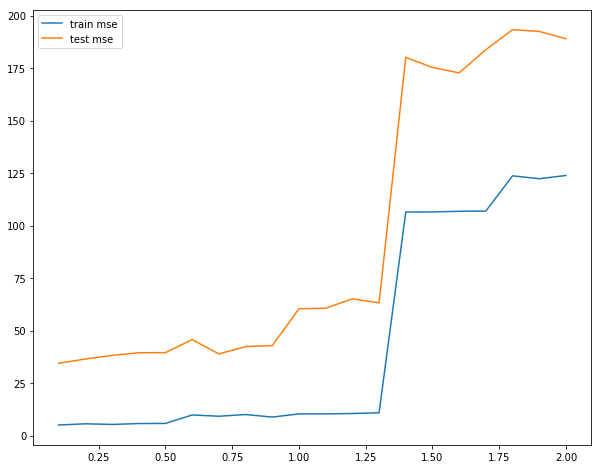

In [41]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(scores.threshold, scores['train mse'], label='train mse')
ax.plot(scores.threshold, scores['test mse'], label='test mse')
ax.legend();

Test score is better than training using LassoCV as an estimator, using random forest we get more overfitting but also better overall performances than all the previous methods. The best choice for the threshold seems to be around 0.5.

5 - Create two pipelines for feature selection of a technique of your choice, scaling the data before hand.  Then, join these two pipelines with a `FeatureUnion`, and fit a polynomial model, also in a pipeline.  Comment on your results.

In [42]:
# joining select from model using lasso and select k best using the best parameters from before
pipe = Pipeline([
    ('scl', StandardScaler()),
    ('featsel', FeatureUnion([
        ('sfmod', SelectFromModel(LassoCV(), threshold='0.5*mean')),
        ('best', SelectKBest(k=6))
    ])),
    ('poly', PolynomialFeatures(degree=3)),
    ('lr', LinearRegression())
])

In [43]:
pipe.fit(Xtrain, ytrain)
print(pipe.score(Xtrain, ytrain))
print(pipe.score(Xtest, ytest))

0.894859371926
0.817670756555


In [45]:
print(mean_squared_error(pipe.predict(Xtrain), ytrain))
print(mean_squared_error(pipe.predict(Xtest), ytest))

29.868636857
46.9827978423


In [44]:
pipe.named_steps['poly'].n_input_features_

11

By joining the pipelines I get the features from both the feature selections (which is quite strange as a model) but I get a very good test score of 81% (which is still worse than the 84% obtained only with poly features).

## Evaluation Metrics
It is very important that you have more than one tool in your toolbox for evaluating the usefulness of your model, as in different context, different metrics are preferred.  For example, suppose a new medical test is developed for detecting cancer that has a 0.25 probability of incorrectly labeling a patient of having cancer when they in fact do not, but a 0.001 probability of labeling a cancer patient as cancer free.  With this sort of test, you can be sure that those who do have cancer will almost certainly be classified correctly, but a positive does not necessarily mean that the patient has cancer, meaning additional tests are in order.  These metrics have different names and depending on the situation, you may be interested in minimizing different quantities, which is the topic we will explore in this exercise.

1 - Head over the [Machine Learning Repository](http://archive.ics.uci.edu/ml/) and download the [Breast Cancer Diagnostic Dataset](http://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29), put it in a dataframe, and split into testing and training sets.

In [46]:
breast = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data',
                     header=None)

breast.columns = ['id','clump_thickness','uniformity_cell_size','uniformity_cell_shape','marginal_adhesion',
                'single_epithelial_cell_size','bare_nuclei','bland_chromatin','normal_nucleoli','mitoses','class']

In [4]:
breast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
id                             699 non-null int64
clump_thickness                699 non-null int64
uniformity_cell_size           699 non-null int64
uniformity_cell_shape          699 non-null int64
marginal_adhesion              699 non-null int64
single_epithelial_cell_size    699 non-null int64
bare_nuclei                    699 non-null object
bland_chromatin                699 non-null int64
normal_nucleoli                699 non-null int64
mitoses                        699 non-null int64
class                          699 non-null int64
dtypes: int64(10), object(1)
memory usage: 60.1+ KB


Bare nuclei is an object: this is due to the presence of ? for missing values, which I'm going to replace with 1s.

In [5]:
breast.bare_nuclei.value_counts()

1     402
10    132
5      30
2      30
3      28
8      21
4      19
?      16
9       9
7       8
6       4
Name: bare_nuclei, dtype: int64

In [47]:
breast.bare_nuclei = breast.bare_nuclei.apply(lambda x: x.replace('?', '1'))
breast.bare_nuclei = pd.to_numeric(breast.bare_nuclei)

Also, I'm encoding the class column with 0s and 1s:

In [48]:
# 2 for benign, 4 for malignant
le = LabelEncoder()
le.fit([2, 4])
breast['class'] = le.transform(breast['class'])

In [21]:
breast.describe().T

,count,mean,std,min,25%,50%,75%,max
id,699.0,1.071704e+06,617095.729819,61634.0,870688.5,1171710.0,1238298.0,13454352.0
clump_thickness,699.0,4.417740e+00,2.815741,1.0,2.0,4.0,6.0,10.0
uniformity_cell_size,699.0,3.134478e+00,3.051459,1.0,1.0,1.0,5.0,10.0
uniformity_cell_shape,699.0,3.207439e+00,2.971913,1.0,1.0,1.0,5.0,10.0
marginal_adhesion,699.0,2.806867e+00,2.855379,1.0,1.0,1.0,4.0,10.0
single_epithelial_cell_size,699.0,3.216023e+00,2.214300,1.0,2.0,2.0,4.0,10.0
bare_nuclei,699.0,3.486409e+00,3.621929,1.0,1.0,1.0,5.0,10.0
bland_chromatin,699.0,3.437768e+00,2.438364,1.0,2.0,3.0,5.0,10.0
normal_nucleoli,699.0,2.866953e+00,3.053634,1.0,1.0,1.0,4.0,10.0
mitoses,699.0,1.589413e+00,1.715078,1.0,1.0,1.0,1.0,10.0


In [49]:
Xtrain, Xtest, ytrain, ytest = train_test_split(breast.drop('class', axis=1), breast['class'], test_size=0.2, random_state=0)

2 - Using a classification algorithm of your choice, fit a model to the data and predict the results, making your results as accurate as possible.

In [50]:
# scale and KNN
pipe = Pipeline([
    ('scl', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

In [51]:
scores = []
# looping through number of neighbors
for k in range(1, 20):
    pipe.set_params(knn__n_neighbors=k)
    temp = cross_val_score(estimator=pipe, X=Xtrain, y=ytrain, cv=10)
    scores.append([k, np.mean(temp), np.std(temp)])

scores = pd.DataFrame(scores)
scores.columns = ['k', 'kfold mean', 'kfold std']

In [52]:
scores.sort_values(by='kfold mean', ascending=False)

,k,kfold mean,kfold std
6,7,0.964564,0.032230
16,17,0.962746,0.037112
14,15,0.962746,0.037112
7,8,0.962715,0.031764
18,19,0.960960,0.036562
12,13,0.960960,0.036562
15,16,0.960928,0.037468
4,5,0.960928,0.030001
5,6,0.960928,0.031083
11,12,0.960897,0.031133


Seven is the number of neighbors with the best CV score:

In [53]:
pipe.set_params(knn__n_neighbors=7)
pipe.fit(Xtrain, ytrain)
pipe.score(Xtest, ytest)

0.97857142857142854

The accuracy is almost 98%, which is quite good!

3 - Using your model in part (2), compute the following quantities, without using `skelarn.metrics`.
    - True Positives
    - True Negatives
    - False Positives
    - False Negatives

In [27]:
ypred = pipe.predict(Xtest)

In [28]:
TP = sum((ypred[ytest==1]==ytest.values[ytest.values==1]))
TN = sum((ypred[ytest==0]==ytest.values[ytest.values==0]))
FP = sum((ypred[ytest==0]!=ytest.values[ytest.values==0]))
FN = sum((ypred[ytest==1]!=ytest.values[ytest.values==1]))

In [29]:
print('True Positives: {}\nTrue Negatives: {}\nFalse Positives: {}\nFalse Negatives: {}'.format(TP, TN, FP, FN))

True Positives: 54
True Negatives: 83
False Positives: 2
False Negatives: 1


4 -  Using your results in part (3), compute the following quantities.
    - Sensitivity, recall, hit rate, or true positive rate (TPR)
    - Specificity or true negative rate (TNR)
    - Miss rate or false negative rate (FNR)
    - Fall-out or false positive rate (FPR)
    - Precision
    - F1
    - Accuracy

In [30]:
TPR = TP / (FN+TP)
FPR = FP / (FP+TN)
TNR = 1 - FPR
FNR = 1 - TPR
PRE = TP / (TP+FP)
F1 = 2*PRE*TPR / (PRE+TPR)
ACC = (TP+TN) / len(ypred)

In [31]:
print('TPR: {}\nTNR: {}\nFNR: {}\nFPR: {}\nPRE: {}\nF1: {}\nACC: {}'.format(TPR, TNR, FNR, FPR, PRE, F1, ACC))

TPR: 0.9818181818181818
TNR: 0.9764705882352941
FNR: 0.018181818181818188
FPR: 0.023529411764705882
PRE: 0.9642857142857143
F1: 0.972972972972973
ACC: 0.9785714285714285


5 - Check your results in part (4) using `sklearn`.

In [32]:
print(confusion_matrix(y_true=ytest, y_pred=ypred))
print('TPR', recall_score(ytest, ypred))
print('PRE', precision_score(y_true=ytest, y_pred=ypred))
print('F1', f1_score(y_true=ytest, y_pred=ypred))
print('ACC', accuracy_score(y_true=ytest, y_pred=ypred))

[[83  2]
 [ 1 54]]
TPR 0.981818181818
PRE 0.964285714286
F1 0.972972972973
ACC 0.978571428571


6 - Plot the precision and recall curve for your fit.

In [34]:
ypredprob = pipe.predict_proba(Xtest)

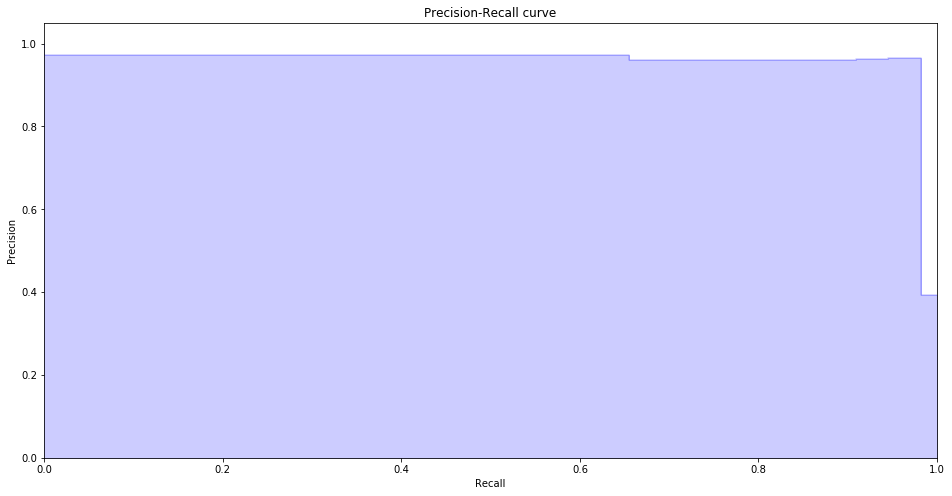

In [44]:
# get precision and recall values
precision, recall, _ = precision_recall_curve(ytest, ypredprob[:, 1])
# plot them and fill the curve
plt.figure(figsize=(16, 8))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve');

7 - Plot the ROC curve for your fit.

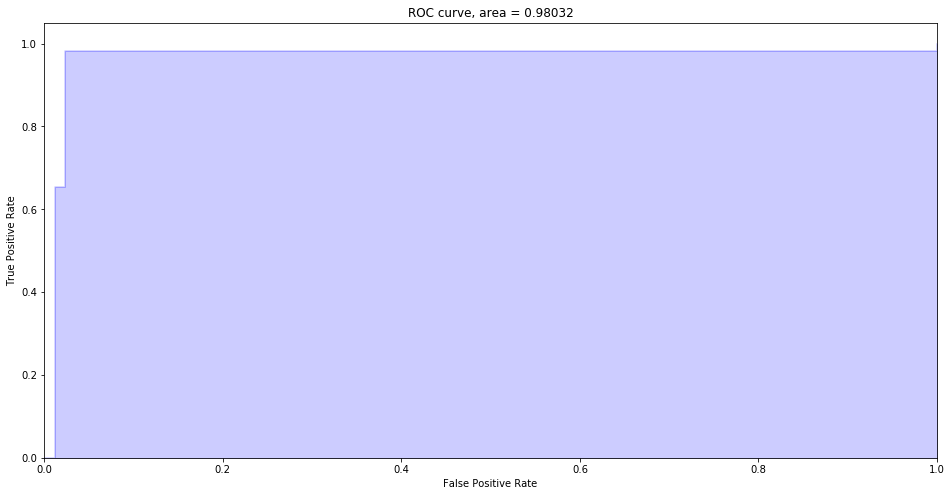

In [49]:
# getting FPR and TPR for the ROC curve and the area under it
fpr, tpr, _ = roc_curve(ytest, ypredprob[:, 1])
roc_auc = roc_auc_score(ytest, ypredprob[:, 1])
# plot and fill the curve
plt.figure(figsize=(16, 8))
plt.step(fpr, tpr, color='b', alpha=0.2, where='post')
plt.fill_between(fpr, tpr, step='post', alpha=0.2, color='b')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('ROC curve, area = {:.5f}'.format(roc_auc));

## Learning and Evaluation Curves, Hyperparameter Tuning, and Bootstrapping
A problem that you will see crop up time and time again in Data Science is overfitting.  Much like how people can sometimes see structure where there is none, machine learning algorithms suffer from the same.  If you have overfit your model to your data, it has learned a "pattern" in the noise rather than the signal you were looking for, and thus will not generalize well to data it has not seen.

Consider the LASSO Regression model which we have used previously.  Like all parametric models, fitting a LASSO Regression model can be reduced to the problem of finding a set of $\hat{\theta_i}$ which minimize the cost function given the data.  But notice that unlike a standard linear regression model, LASSO Regression has an additional regularization parameter.  The result of this is that the $\hat{\theta_i}$ are dependent not only on our data, but also on this additional hyperparameter.

So now we have three different problems to juggle while we are fitting our models: overfitting, underfitting, and hyperparameter tuning.  A common technique to deal with all three is cross-validation which we will explore in this exercise.

Also, you may find yourself in a situation where you do not have enough data to build a good model.  Again, with some simple assumptions, we can "pull ourselves up by our bootstraps", and get by reasonably well with the data we have using a method called bootstrapping.

In this exercise, you'll explore these topics using the `wine` dataset.

1 - Head over to the [Machine Learning Repository](http://archive.ics.uci.edu/ml/index.php), download the [Wine Dataset](http://archive.ics.uci.edu/ml/datasets/Wine), and put it in a dataframe, being sure to label the columns properly.

In [54]:
wine = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
# wine = pd.read_csv('wine.data', header=None)
wine.columns = ['class', 'alcohol', 'malic_acid', 'ash', 'alcalinity_ash', 'magnesium',
                'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity',
                'hue', 'OD280_OD315', 'proline']

In [4]:
wine.head()

,class,alcohol,malic_acid,ash,alcalinity_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,OD280_OD315,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [5]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
class                   178 non-null int64
alcohol                 178 non-null float64
malic_acid              178 non-null float64
ash                     178 non-null float64
alcalinity_ash          178 non-null float64
magnesium               178 non-null int64
total_phenols           178 non-null float64
flavanoids              178 non-null float64
nonflavanoid_phenols    178 non-null float64
proanthocyanins         178 non-null float64
color_intensity         178 non-null float64
hue                     178 non-null float64
OD280_OD315             178 non-null float64
proline                 178 non-null int64
dtypes: float64(11), int64(3)
memory usage: 19.5 KB


In [6]:
wine.describe().T

,count,mean,std,min,25%,50%,75%,max
class,178.0,1.938202,0.775035,1.00,1.0000,2.000,3.0000,3.00
alcohol,178.0,13.000618,0.811827,11.03,12.3625,13.050,13.6775,14.83
malic_acid,178.0,2.336348,1.117146,0.74,1.6025,1.865,3.0825,5.80
ash,178.0,2.366517,0.274344,1.36,2.2100,2.360,2.5575,3.23
alcalinity_ash,178.0,19.494944,3.339564,10.60,17.2000,19.500,21.5000,30.00
magnesium,178.0,99.741573,14.282484,70.00,88.0000,98.000,107.0000,162.00
total_phenols,178.0,2.295112,0.625851,0.98,1.7425,2.355,2.8000,3.88
flavanoids,178.0,2.029270,0.998859,0.34,1.2050,2.135,2.8750,5.08
nonflavanoid_phenols,178.0,0.361854,0.124453,0.13,0.2700,0.340,0.4375,0.66
proanthocyanins,178.0,1.590899,0.572359,0.41,1.2500,1.555,1.9500,3.58


In [47]:
# Xtrain, Xtest, ytrain, ytest = train_test_split(wine.drop('class', axis=1),
#                                                 wine['class'],
#                                                 test_size=0.2,
#                                                 random_state=5,
#                                                 stratify=wine['class'])

2 - Separate your data into train and test sets, of portions ranging from `test_size = 0.99` to `test_size = 0.01`, fitting a logistic regression model to each and computing the training and test errors.  Plot the errors of the training and test sets on the same plot.  Do this without using `sklearn.model_select.learning_curve`.  Comment on your results.

In [55]:
# scaling and logistic regression
pipe = Pipeline([
        ('scl', StandardScaler()),
        ('lr', LogisticRegression())
    ])

scores = []
# looping through test sizes from 0.98 to 0.02 (0.99 gave error because I didn't have all the classes in the split)
# for tsize in np.arange(0.98, 0.01, -0.01):
for tsize in np.arange(0.01, 0.99, 0.01):
    # splitting
    Xtr, Xts, ytr, yts = train_test_split(wine.drop('class', axis=1),
                                            wine['class'],
                                            test_size=tsize,
                                            random_state=1,
                                            # stratify=wine['class'] # not used in solutions
                                         )
    # fit and score
    pipe.fit(Xtr, ytr)
    scores.append([tsize, pipe.score(Xtr, ytr), pipe.score(Xts, yts)])

scores = np.array(scores)

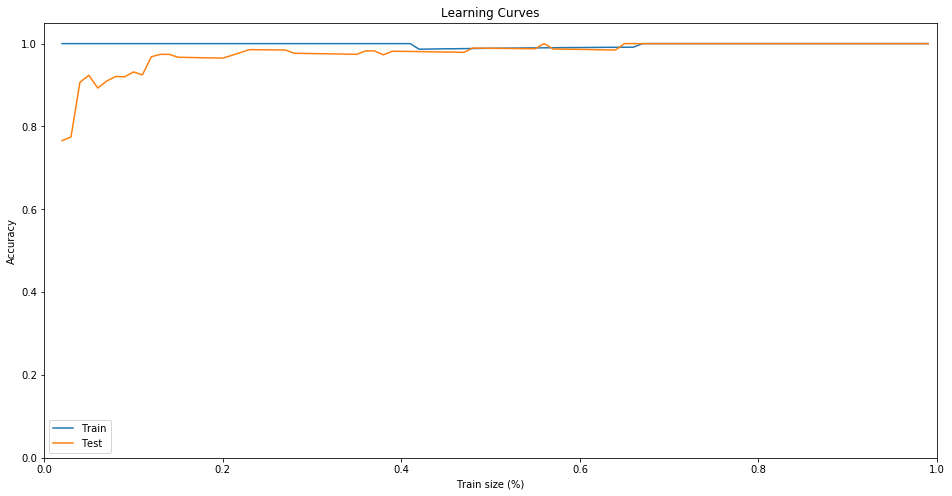

In [56]:
# plot train and test scores by increasing train size (1-test size)
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(1 - scores[:, 0], scores[:, 1], label='Train')
ax.plot(1 - scores[:, 0], scores[:, 2], label='Test')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.05])
ax.set_xlabel('Train size (%)')
ax.set_ylabel('Accuracy')
ax.set_title('Learning Curves')
ax.legend();

As expected the test accuracy goes up when the train size is increased; strangely we always get 100% accuracy on the training set.

In the solution without scaling the results are worse, let's try it out:

In [57]:
lr = LogisticRegression()

scores = []
for tsize in np.arange(0.01, 0.99, 0.01):
    # splitting
    Xtr, Xts, ytr, yts = train_test_split(wine.drop('class', axis=1),
                                            wine['class'],
                                            test_size=tsize,
                                            random_state=1,
                                         )
    # fit and score
    lr.fit(Xtr, ytr)
    scores.append([tsize, lr.score(Xtr, ytr), lr.score(Xts, yts)])

scores = np.array(scores)

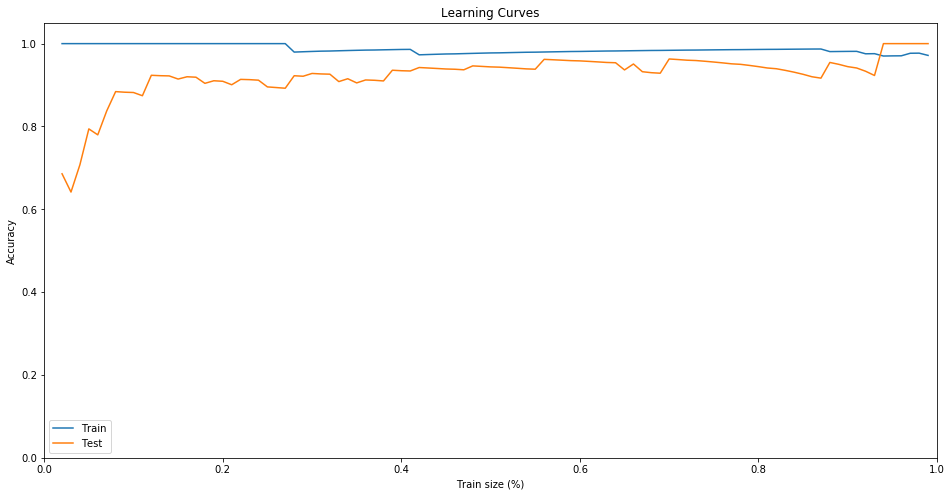

In [58]:
# plot train and test scores by increasing train size (1-test size)
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(1 - scores[:, 0], scores[:, 1], label='Train')
ax.plot(1 - scores[:, 0], scores[:, 2], label='Test')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.05])
ax.set_xlabel('Train size (%)')
ax.set_ylabel('Accuracy')
ax.set_title('Learning Curves')
ax.legend();

Still a bit different...

3 - Repeat part (2) but this time using `sklearn.model_select.learning_curve`.  Comment on your results.

In [77]:
train_sizes, train_scores, test_scores = learning_curve(pipe,
                                                        wine.drop('class', axis=1),
                                                        wine['class'],
                                                        train_sizes=np.arange(0.35, 0.99, 0.01),
                                                        cv=10,
                                                        random_state=5)

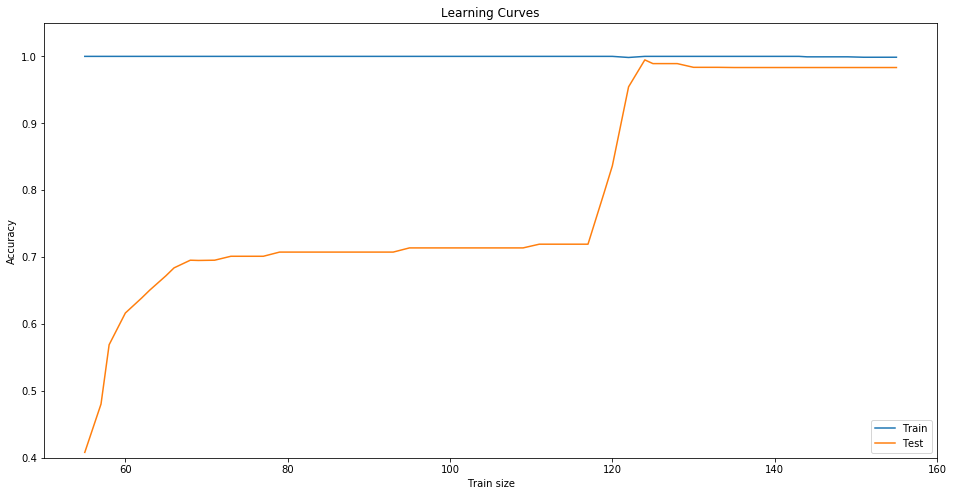

In [130]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(train_sizes, train_scores.mean(axis=1), label='Train')
ax.plot(train_sizes, test_scores.mean(axis=1), label='Test')
ax.set_ylim([0.4, 1.05])
ax.set_xlabel('Train size')
ax.set_ylabel('Accuracy')
ax.set_title('Learning Curves')
ax.legend();

Using learning curves the accuracy on the training set is always perfect, while the test accuracy increases without getting to 100%: this may be because learning curve uses cross validation and so we are less dependent on the splits.

4 - Use K-Fold cross validation to tune the regularization strength parameter of the logistic regression.  Do this for values of `k` ranging from `2` to `5`, make relevant  plots, and comment on your results.  Do this without using `sklearn.model_select.evaluation_curve`.

In [146]:
# using grid search which uses k-fold cv by default
param_range = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000, 3000]
param_grid = [{'lr__C': param_range}]
gs = GridSearchCV(estimator=pipe, 
                  param_grid=param_grid)

scores = {}
best_scores = {}
# looping through number of folds
for k in [2, 3, 4, 5]:
    # set params
    gs.set_params(cv=k)
    # fit
    gs.fit(wine.drop('class', axis=1), wine['class'])
    # saving best scores and mean scores for all params
    best_scores[k] = [gs.best_params_['lr__C'], gs.best_score_]
    scores[k] = np.array([param_range, gs.cv_results_['mean_train_score'], gs.cv_results_['mean_test_score']]).T

In [155]:
best_scores

{2: [1000, 0.9831460674157303],
 3: [30, 0.97752808988764039],
 4: [0.1, 0.9719101123595506],
 5: [1, 0.9831460674157303]}

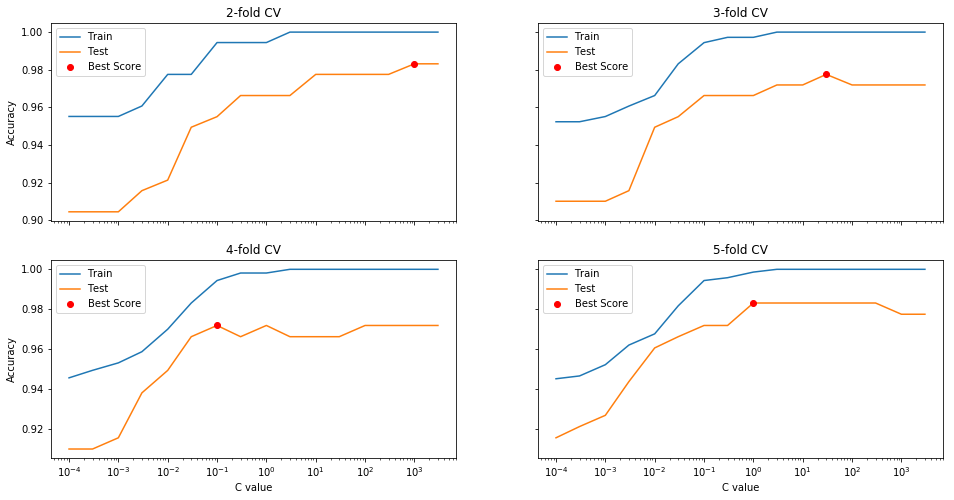

In [148]:
# creating 4 plots, one for each number of fold
fig, ax = plt.subplots(2, 2, figsize=(16, 8), sharex='col', sharey='row', subplot_kw=dict(xscale='log'))
i, j = 0, 0

for k in scores:
    # plotting train and test scores and the best score
    ax[i, j].plot(scores[k][:, 0], scores[k][:, 1], label='Train')
    ax[i, j].plot(scores[k][:, 0], scores[k][:, 2], label='Test')
    ax[i, j].plot(best_scores[k][0], best_scores[k][1], 'ro', label='Best Score')
    ax[i, j].set_title('{}-fold CV'.format(k))
    if j == 0:
        ax[i, j].set_ylabel('Accuracy')
    if i == 1:
        ax[i, j].set_xlabel('C value')
    ax[i, j].legend()
    j += 1
    if j == 2:
        j = 0
        i += 1

Training scores are very similar in each of the plots, there are some differences between the test accuracy curves where the best value for C seems to go towards 1.

In [63]:
# solution:
X = wine.drop('class', axis=1)
y = wine['class']

k_vals = np.arange(2, 6, 1)
c_vals = np.arange(0.5, 1.5, 0.05)
err = []
for k in k_vals:
    for c in c_vals:
        lm = LogisticRegression(C=c)
        temp_err = cross_val_score(lm, X=X, y=y, cv=k)
        
        err_dict = {}
        err_dict['k'] = k
        err_dict['c'] = c
        err_dict['acc'] = temp_err.mean()
        
        err.append(err_dict)
    
err = pd.DataFrame(err)

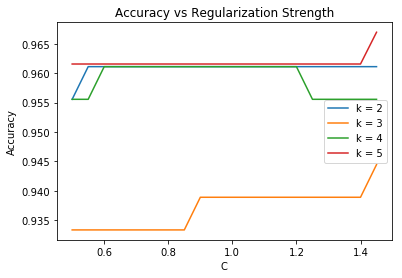

In [64]:
for k in err.k.unique():
    plt.plot(c_vals, err.acc[err.k == k], label='k = {}'.format(k))
plt.title('Accuracy vs Regularization Strength')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend();

5 - Tune the regularization strength parameter as in part (4), but this time using `sklearn.model_select.evaluation_curve`.  Comment on your results.

In [142]:
scores = {}
best_scores = {}

for k in [2, 3, 4, 5]:
    # validation cruve uses cv and wants params similar to grid search
    train_scores, test_scores = validation_curve(estimator=pipe,
                                                X=wine.drop('class', axis=1),
                                                y=wine['class'],
                                                param_name='lr__C',
                                                param_range=param_range,
                                                cv=k)
    # saving mean scores
    mean_train_scores = train_scores.mean(axis=1)
    mean_test_scores = test_scores.mean(axis=1)
    # and best scores
    best_scores[k] = [param_range[mean_test_scores.argmax()], mean_test_scores[mean_test_scores.argmax()]]
    scores[k] = np.array([param_range, mean_train_scores, mean_test_scores]).T

In [154]:
best_scores

{2: [1000, 0.9831460674157303],
 3: [30, 0.97752808988764039],
 4: [0.1, 0.9719101123595506],
 5: [1, 0.9831460674157303]}

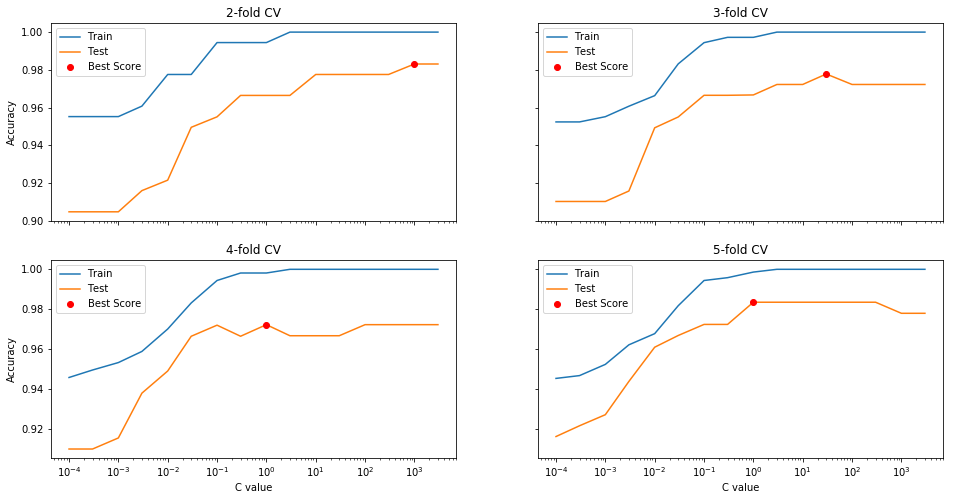

In [143]:
fig, ax = plt.subplots(2, 2, figsize=(16, 8), sharex='col', sharey='row', subplot_kw=dict(xscale='log'))
i, j = 0, 0

for k in scores:
    ax[i, j].plot(scores[k][:, 0], scores[k][:, 1], label='Train')
    ax[i, j].plot(scores[k][:, 0], scores[k][:, 2], label='Test')
    ax[i, j].plot(best_scores[k][0], best_scores[k][1], 'ro', label='Best Score')
    ax[i, j].set_title('{}-fold CV'.format(k))
    if j == 0:
        ax[i, j].set_ylabel('Accuracy')
    if i == 1:
        ax[i, j].set_xlabel('C value')
    ax[i, j].legend()
    j += 1
    if j == 2:
        j = 0
        i += 1

The plots are the same as above.

6 - Fit another classification algorithm to the data, tuning the parameter using LOOCV.  Comment on your results.

In [153]:
pipe = Pipeline([
    ('scl', StandardScaler()),
    ('svm', SVC())
])
# using grid search with LeaveOneOut as cv
param_range = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000, 3000]
param_grid = [{'svm__C': param_range}]

# in solution: cross_val_score(pipe, X, y, cv=LeaveOneOut()) used looping through params values
gs = GridSearchCV(estimator=pipe, 
                  param_grid=param_grid,
                  cv=LeaveOneOut())

gs.fit(wine.drop('class', axis=1), wine['class'])
gs.best_params_['svm__C'], gs.best_score_

(0.3, 0.9887640449438202)

Using LOOCV I get 0.3 as the best choice for C and an accuracy of almost 99%, which is slightly higher than before.

7 - Suppose that the wine data the we received was incomplete, containing, say, only 20% of the full set, but due to a fast approaching deadline, we need to still compute some statistics and fit a model.  Use bootstrapping to compute the mean and variance of the features, and fit the classification model you used in part (4), comparing and commenting on your results with those from the full dataset.

In [6]:
# resampling 5 times the data
wine_strapped = resample(wine, n_samples=len(wine)*5, random_state=10)

In [67]:
# solution: leaves 80% of the data out and bootstraps the remaining 20%:

data_sub_test, data_sub = train_test_split(wine, test_size=0.2, random_state=0)
data_boot = data_sub.sample(n=150, replace=True, random_state=0)

In [69]:
# still from solution:
means = {'original': wine.drop('class', axis=1).mean(),
        '20%': data_sub.drop('class', axis=1).mean(),
        'bootstrap%': data_boot.drop('class', axis=1).mean()}

var = {'original': wine.drop('class', axis=1).var(),
        '20%': data_sub.drop('class', axis=1).var(),
        'bootstrap%': data_boot.drop('class', axis=1).var()}

means = pd.DataFrame(means)
var = pd.DataFrame(var)

In [70]:
means

,20%,bootstrap%,original
alcohol,13.062778,13.120800,13.000618
malic_acid,2.193333,2.079067,2.336348
ash,2.365000,2.335200,2.366517
alcalinity_ash,19.258333,18.923333,19.494944
magnesium,98.472222,99.346667,99.741573
total_phenols,2.438889,2.473600,2.295112
flavanoids,2.345278,2.393733,2.029270
nonflavanoid_phenols,0.355278,0.335400,0.361854
proanthocyanins,1.531111,1.590000,1.590899
color_intensity,5.108889,5.156467,5.058090


In [72]:
var

,20%,bootstrap%,original
alcohol,0.703249,0.638096,0.659062
malic_acid,1.273366,1.259058,1.248015
ash,0.087626,0.077578,0.075265
alcalinity_ash,8.585357,8.545962,11.152686
magnesium,211.570635,211.744787,203.989335
total_phenols,0.446822,0.454517,0.391690
flavanoids,1.079951,1.063656,0.997719
nonflavanoid_phenols,0.012568,0.013073,0.015489
proanthocyanins,0.243930,0.275603,0.327595
color_intensity,4.348679,3.965832,5.374449


In [79]:
# last from solution:

pipe = Pipeline([
        ('scl', StandardScaler()),
        ('lr', LogisticRegression())
    ])

pipe.set_params(lr__C=1)
pipe.fit(wine.drop('class', axis=1), wine['class'])
print(cross_val_score(pipe, wine.drop('class', axis=1), wine['class'], cv=5).mean())

pipe.fit(data_boot.drop('class', axis=1), data_boot['class'])
print(cross_val_score(pipe, data_sub_test.drop('class', axis=1), data_sub_test['class'], cv=5).mean())

0.983483483483
0.951231527094


In [7]:
wine.describe().T

,count,mean,std,min,25%,50%,75%,max
class,178.0,1.938202,0.775035,1.00,1.0000,2.000,3.0000,3.00
alcohol,178.0,13.000618,0.811827,11.03,12.3625,13.050,13.6775,14.83
malic_acid,178.0,2.336348,1.117146,0.74,1.6025,1.865,3.0825,5.80
ash,178.0,2.366517,0.274344,1.36,2.2100,2.360,2.5575,3.23
alcalinity_ash,178.0,19.494944,3.339564,10.60,17.2000,19.500,21.5000,30.00
magnesium,178.0,99.741573,14.282484,70.00,88.0000,98.000,107.0000,162.00
total_phenols,178.0,2.295112,0.625851,0.98,1.7425,2.355,2.8000,3.88
flavanoids,178.0,2.029270,0.998859,0.34,1.2050,2.135,2.8750,5.08
nonflavanoid_phenols,178.0,0.361854,0.124453,0.13,0.2700,0.340,0.4375,0.66
proanthocyanins,178.0,1.590899,0.572359,0.41,1.2500,1.555,1.9500,3.58


In [8]:
wine_strapped.describe().T

,count,mean,std,min,25%,50%,75%,max
class,890.0,1.926966,0.779557,1.00,1.0000,2.00,3.00,3.00
alcohol,890.0,13.012371,0.817597,11.03,12.3700,13.05,13.71,14.83
malic_acid,890.0,2.305820,1.080373,0.74,1.5900,1.83,3.10,5.80
ash,890.0,2.363079,0.275447,1.36,2.2100,2.36,2.56,3.23
alcalinity_ash,890.0,19.367978,3.310979,10.60,17.0000,19.00,21.50,30.00
magnesium,890.0,99.713483,14.150085,70.00,88.0000,98.00,108.00,162.00
total_phenols,890.0,2.331596,0.634766,0.98,1.7825,2.42,2.85,3.88
flavanoids,890.0,2.064978,1.014961,0.34,1.1000,2.17,2.92,5.08
nonflavanoid_phenols,890.0,0.356202,0.126038,0.13,0.2600,0.32,0.43,0.66
proanthocyanins,890.0,1.616697,0.577095,0.41,1.2500,1.56,1.97,3.58


In [9]:
pipe = Pipeline([
        ('scl', StandardScaler()),
        ('lr', LogisticRegression())
    ])
# using grid search to fit the best logistic regression
param_range = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000, 3000]
param_grid = [{'lr__C': param_range}]
gs = GridSearchCV(estimator=pipe, 
                  param_grid=param_grid)

scores = {}
best_scores = {}
# looping through number of folds
for k in [2, 3, 4, 5]:
    gs.set_params(cv=k)
    gs.fit(wine_strapped.drop('class', axis=1), wine_strapped['class'])
    best_scores[k] = [gs.best_params_['lr__C'], gs.best_score_]
    scores[k] = np.array([param_range, gs.cv_results_['mean_train_score'], gs.cv_results_['mean_test_score']]).T

In [10]:
best_scores

{2: [1, 1.0], 3: [1, 1.0], 4: [1, 1.0], 5: [1, 1.0]}

In all the cases I get 100% accuracy!

## Model Selection
All that has been within the previous sections is part of the much broader topic known as model selection.  Model selection is not only about choosing the right machine learning algorithm to use, but also about tuning parameters while keeping overfitting and scalability issues in mind.  In this exercise, we'll build models for a couple different datasets, using all of the concepts you've worked with previously.

### Classification
1 - Head over to the [Machine Learning Repository](http://archive.ics.uci.edu/ml/index.php), download the [Mushroom Data Set](http://archive.ics.uci.edu/ml/datasets/Mushroom), and put it into a dataframe.  Be sure to familiarize yourself with the data before proceeding.  Break the data into training and testing sets.  Be sure to keep this testing set the same for the duration of this exercise as we will be using to test various algorithms!

In [80]:
shrooms = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data', header=None)
shrooms.columns = ['poisonous', 'cap_shape', 'cap_surface', 'cap_color', 'bruises', 'odor', 'gill_attachment', 'gill_spacing',
                   'gill_size', 'gill_color', 'stalk_shape', 'stalk_root', 'stalk_surface_above_ring',
                   'stalk_surface_below_ring', 'stalk_color_above_ring', 'stalk_color_below_ring', 'veil_type',
                   'veil_color', 'ring_number', 'ring_type', 'spore_print_color', 'population', 'habitat']

In [49]:
shrooms.head()

,poisonous,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,...,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [50]:
shrooms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
poisonous                   8124 non-null object
cap_shape                   8124 non-null object
cap_surface                 8124 non-null object
cap_color                   8124 non-null object
bruises                     8124 non-null object
odor                        8124 non-null object
gill_attachment             8124 non-null object
gill_spacing                8124 non-null object
gill_size                   8124 non-null object
gill_color                  8124 non-null object
stalk_shape                 8124 non-null object
stalk_root                  8124 non-null object
stalk_surface_above_ring    8124 non-null object
stalk_surface_below_ring    8124 non-null object
stalk_color_above_ring      8124 non-null object
stalk_color_below_ring      8124 non-null object
veil_type                   8124 non-null object
veil_color                  8124 non-null object
ring_number

In [51]:
shrooms.describe().T

,count,unique,top,freq
poisonous,8124,2,e,4208
cap_shape,8124,6,x,3656
cap_surface,8124,4,y,3244
cap_color,8124,10,n,2284
bruises,8124,2,f,4748
odor,8124,9,n,3528
gill_attachment,8124,2,f,7914
gill_spacing,8124,2,c,6812
gill_size,8124,2,b,5612
gill_color,8124,12,b,1728


We have 2480 missing values for stalk_root (denoted by ?), which I'm going to keep as they are since this is a category.

I'm dropping veil_type instead because it has only 1 class.

In [81]:
shrooms.drop('veil_type', axis=1, inplace=True)

In [82]:
Xtrain, Xtest, ytrain, ytest = train_test_split(shrooms.drop('poisonous', axis=1),
                                                shrooms.poisonous,
                                                test_size=0.2,
                                                random_state=42)

Also, I'm relabeling the poisonous mushrooms as 1 and not poisonous ones as 0.

In [83]:
ytrain = ytrain.apply(lambda x: 1 if x == 'p' else 0)
ytest = ytest.apply(lambda x: 1 if x == 'p' else 0)

2 - Fit a machine learning algorithm of your choice to the data, tuning hyperparameters using the Better Holdout Method.  Generate training and validation plots and comment on your results.

In [ ]:
# in solution he encodes all variables once using df.apply(le.fit_transform)

This is a class to perform label encoding on multiple columns:

In [84]:
class MultiLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname, col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

#     def fit_transform(self, X, y=None):
#         return self.fit(X, y).transform(X)
    
#     def get_params(self):
#         return 'columns'
    
#     def set_params(self, param, value):
#         self.param = value

In [85]:
# encode, one hot encode and then KNN
pipe = Pipeline([
    ('mle', MultiLabelEncoder()),
    ('ohe', OneHotEncoder()),
    ('knn', KNeighborsClassifier())
])

In [57]:
# better holdout
Xtr, Xcv, ytr, ycv = train_test_split(Xtrain, ytrain, test_size=0.2, random_state=42)
scores = []
# looping through various neighbors number
for k in range(1, 21):
    pipe.set_params(knn__n_neighbors=k)
    pipe.fit(Xtr, ytr)
    tr_score = pipe.score(Xtr, ytr)
    cv_score = pipe.score(Xcv, ycv)
    scores.append([k, tr_score, cv_score])

scores = np.array(scores)

In [58]:
scores

array([[  1.        ,   1.        ,   1.        ],
       [  2.        ,   1.        ,   1.        ],
       [  3.        ,   1.        ,   1.        ],
       [  4.        ,   1.        ,   1.        ],
       [  5.        ,   1.        ,   1.        ],
       [  6.        ,   1.        ,   1.        ],
       [  7.        ,   1.        ,   1.        ],
       [  8.        ,   0.99980766,   0.99846154],
       [  9.        ,   1.        ,   0.99846154],
       [ 10.        ,   0.99884593,   0.99692308],
       [ 11.        ,   0.99903828,   0.99692308],
       [ 12.        ,   0.99884593,   0.99615385],
       [ 13.        ,   0.99903828,   0.99615385],
       [ 14.        ,   0.99846124,   0.99615385],
       [ 15.        ,   0.99884593,   0.99692308],
       [ 16.        ,   0.99846124,   0.99615385],
       [ 17.        ,   0.99865359,   0.99615385],
       [ 18.        ,   0.99846124,   0.99538462],
       [ 19.        ,   0.99846124,   0.99538462],
       [ 20.        ,   0.99846

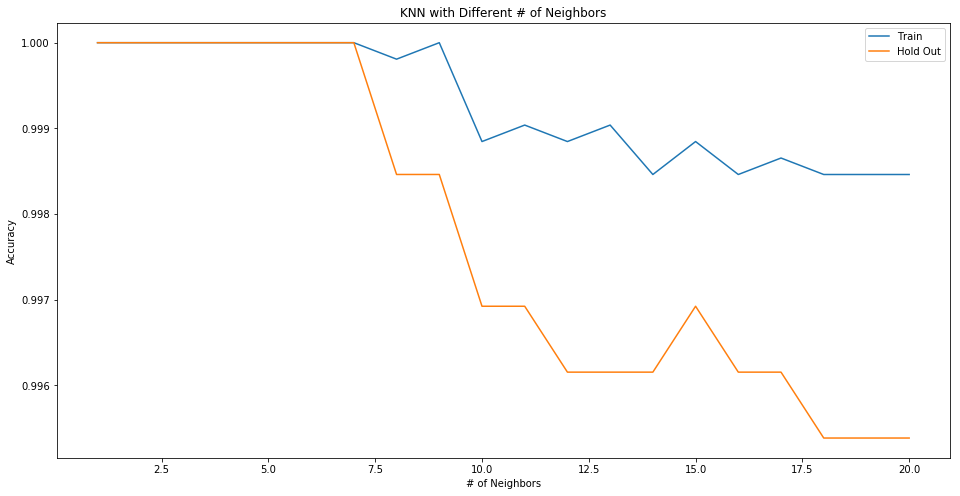

In [59]:
fig, ax = plt.subplots(figsize=(16, 8))
# plotting train and holdout scores
ax.plot(scores[:, 0], scores[:, 1], label='Train')
ax.plot(scores[:, 0], scores[:, 2], label='Hold Out')
ax.set_title('KNN with Different # of Neighbors'.format(k))
ax.set_ylabel('Accuracy')
ax.set_xlabel('# of Neighbors')
ax.legend();

In [60]:
pipe.set_params(knn__n_neighbors=5)
pipe.fit(Xtrain, ytrain)
pipe.score(Xtest, ytest)

1.0

The best results are for a number of neighbors between 2 and 7 (100% accuracy on both train and test set), so I'm going with the default of 5.

3 - Repeat part (2), this time using cross validation.  Comment on your results.

In [86]:
# from solution:

train_scores, test_scores = validation_curve(pipe, Xtrain, ytrain, param_name='knn__n_neighbors', param_range=range(1, 21))

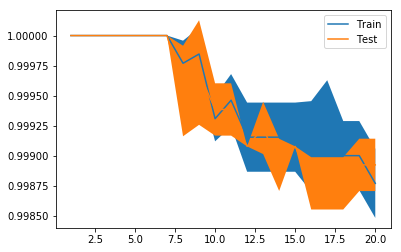

In [89]:
# solution continues:

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.plot(range(1, 21), train_scores_mean, label='Train')
plt.fill_between(range(1, 21), train_scores_mean - train_scores_std, train_scores_mean + train_scores_std)
plt.plot(range(1, 21), test_scores_mean, label='Test')
plt.fill_between(range(1, 21), test_scores_mean - test_scores_std, test_scores_mean + test_scores_std)
plt.legend();

In [61]:
scores = []
# same as above, only using kfold
for k in range(1, 11):
    kfold = KFold(n_splits=10, random_state=1).split(Xtrain, ytrain) # you have to do this every time because the folds
                                                                    # are eliminated after use
    fold_scores = []
    pipe.set_params(knn__n_neighbors=k)
    print('{} Neighbors'.format(k))
    # looping through the folds
    for i, (train, test) in enumerate(kfold):
        # creating train and cv sets
        Xtr, ytr = Xtrain.iloc[train, :], ytrain.iloc[train]
        Xcv, ycv = Xtrain.iloc[test, :], ytrain.iloc[test]
        # fit and score
        pipe.fit(Xtr, ytr)
        tr_score = pipe.score(Xtr, ytr)
        cv_score = pipe.score(Xcv, ycv)
        # append fold scores
        fold_scores.append([i, tr_score, cv_score])
        print('Fold {} done'.format(i+1))
    fold_scores = np.array(fold_scores)
    # append mean and std score of the folds
    scores.append([k, fold_scores.mean(axis=0)[1], fold_scores.mean(axis=0)[2],
                   fold_scores.std(axis=0)[1], fold_scores.std(axis=0)[2]])

scores = np.array(scores)

1 Neighbors
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
2 Neighbors
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
3 Neighbors
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
4 Neighbors
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
5 Neighbors
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
6 Neighbors
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
7 Neighbors
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
8 Neighbors
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 do

In [62]:
scores

array([[  1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  2.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  3.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  4.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  5.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  6.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  7.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  8.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  9.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+01,   9.9989742

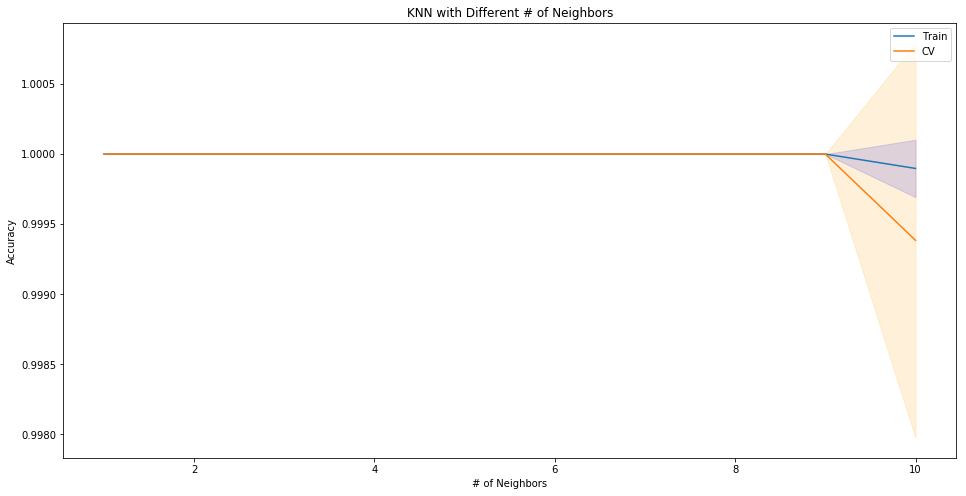

In [63]:
fig, ax = plt.subplots(figsize=(16, 8))
# plotting train and cv mean scores and filling with std
ax.plot(scores[:, 0], scores[:, 1], label='Train')
ax.plot(scores[:, 0], scores[:, 2], label='CV')
ax.fill_between(scores[:, 0],
                 scores[:, 1] + scores[:, 3],
                 scores[:, 1] - scores[:, 3],
                 alpha=0.15, color='blue')
ax.fill_between(scores[:, 0],
                 scores[:, 2] + scores[:, 4],
                 scores[:, 2] - scores[:, 4],
                 alpha=0.15, color='orange')
ax.set_title('KNN with Different # of Neighbors'.format(k))
ax.set_ylabel('Accuracy')
ax.set_xlabel('# of Neighbors')
ax.legend();

We get perfect accuracy for a number of neighbors between 2 and 8 this time; we can also see that we have no variance for this range of values.

4 - Repeat part (3) using a different machine learning algorithm.  Comment on your results.

In [64]:
# encoder and random forest
pipe = Pipeline([
    ('mle', MultiLabelEncoder()),
    #('ohe', OneHotEncoder()),
    ('forest', RandomForestClassifier())
])

In [65]:
scores = []

for k in np.arange(2, 50, 2):
    kfold = KFold(n_splits=10, random_state=1).split(Xtrain, ytrain)
    fold_scores = []
    pipe.set_params(forest__n_estimators=k)
    print('{} Trees'.format(k))
    for i, (train, test) in enumerate(kfold):
        Xtr, ytr = Xtrain.iloc[train, :], ytrain.iloc[train]
        Xcv, ycv = Xtrain.iloc[test, :], ytrain.iloc[test]
        pipe.fit(Xtr, ytr)
        tr_score = pipe.score(Xtr, ytr)
        cv_score = pipe.score(Xcv, ycv)
        fold_scores.append([i, tr_score, cv_score])
        print('Fold {} done'.format(i+1))

    fold_scores = np.array(fold_scores)
    scores.append([k, fold_scores.mean(axis=0)[1], fold_scores.mean(axis=0)[2],
                   fold_scores.std(axis=0)[1], fold_scores.std(axis=0)[2]])

scores = np.array(scores)

2 Trees
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
4 Trees
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
6 Trees
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
8 Trees
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
10 Trees
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
12 Trees
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
14 Trees
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
16 Trees
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
F

In [66]:
scores

array([[  2.00000000e+00,   9.99948709e-01,   9.98000000e-01,
          1.53872457e-04,   3.51160376e-03],
       [  4.00000000e+00,   1.00000000e+00,   9.87384615e-01,
          0.00000000e+00,   3.37957667e-02],
       [  6.00000000e+00,   1.00000000e+00,   9.98923077e-01,
          0.00000000e+00,   2.75638044e-03],
       [  8.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+01,   1.00000000e+00,   9.99538462e-01,
          0.00000000e+00,   1.38461538e-03],
       [  1.20000000e+01,   1.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.40000000e+01,   1.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.60000000e+01,   1.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.80000000e+01,   1.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  2.00000000e+01,   1.0000000

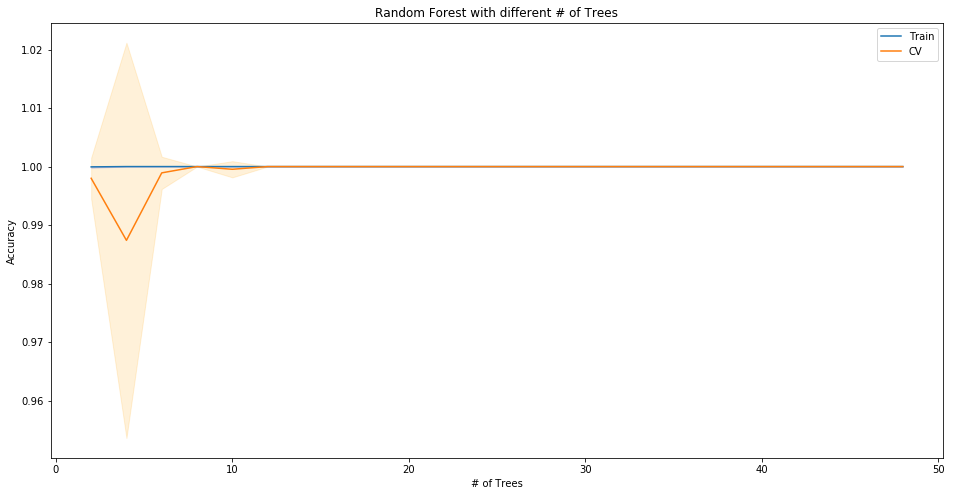

In [67]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(scores[:, 0], scores[:, 1], label='Train')
ax.plot(scores[:, 0], scores[:, 2], label='CV')
ax.fill_between(scores[:, 0],
                 scores[:, 1] + scores[:, 3],
                 scores[:, 1] - scores[:, 3],
                 alpha=0.15, color='blue')
ax.fill_between(scores[:, 0],
                 scores[:, 2] + scores[:, 4],
                 scores[:, 2] - scores[:, 4],
                 alpha=0.15, color='orange')
ax.set_title('Random Forest with different # of Trees'.format(k))
ax.set_ylabel('Accuracy')
ax.set_xlabel('# of Trees')
ax.legend();

In [68]:
pipe.set_params(forest__n_estimators=10)
pipe.fit(Xtrain, ytrain)
pipe.score(Xtest, ytest)

1.0

We get perfect accuracy for about 8 trees or more, so I'm going with the default value of 10.

5 - Which ever of your two algorithms in parts (3) and (4) performed more poorly, perform a variable selection to see if you can improve your results.

In [70]:
mle = MultiLabelEncoder()
pca = PCA()
pca.fit(mle.fit_transform(Xtrain), ytrain)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [71]:
pca.explained_variance_ratio_

array([  3.39467519e-01,   1.64901173e-01,   1.22427133e-01,
         6.88847905e-02,   5.85212974e-02,   5.08395611e-02,
         4.59054537e-02,   3.89389040e-02,   3.56630776e-02,
         2.54799438e-02,   2.01696746e-02,   1.01237071e-02,
         5.57913274e-03,   4.14982185e-03,   3.39576708e-03,
         2.04664212e-03,   1.50135444e-03,   1.23698691e-03,
         4.89268153e-04,   2.23930935e-04,   5.48609943e-05])

Let's try 7 components:

In [72]:
pipe = Pipeline([
    ('mle', MultiLabelEncoder()),
    ('sel', PCA(n_components=7)),
    ('forest', RandomForestClassifier())
])

In [74]:
scores = []

for k in np.arange(2, 22, 2):
    kfold = KFold(n_splits=10, random_state=1).split(Xtrain, ytrain)
    fold_scores = []
    pipe.set_params(forest__n_estimators=k)
    print('{} Trees'.format(k))
    for i, (train, test) in enumerate(kfold):
        Xtr, ytr = Xtrain.iloc[train, :], ytrain.iloc[train]
        Xcv, ycv = Xtrain.iloc[test, :], ytrain.iloc[test]
        pipe.fit(Xtr, ytr)
        tr_score = pipe.score(Xtr, ytr)
        cv_score = pipe.score(Xcv, ycv)
        fold_scores.append([i, tr_score, cv_score])
        print('Fold {} done'.format(i+1))

    fold_scores = np.array(fold_scores)
    scores.append([k, fold_scores.mean(axis=0)[1], fold_scores.mean(axis=0)[2],
                   fold_scores.std(axis=0)[1], fold_scores.std(axis=0)[2]])

scores = np.array(scores)

2 Trees
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
4 Trees
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
6 Trees
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
8 Trees
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
10 Trees
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
12 Trees
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
14 Trees
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
16 Trees
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
F

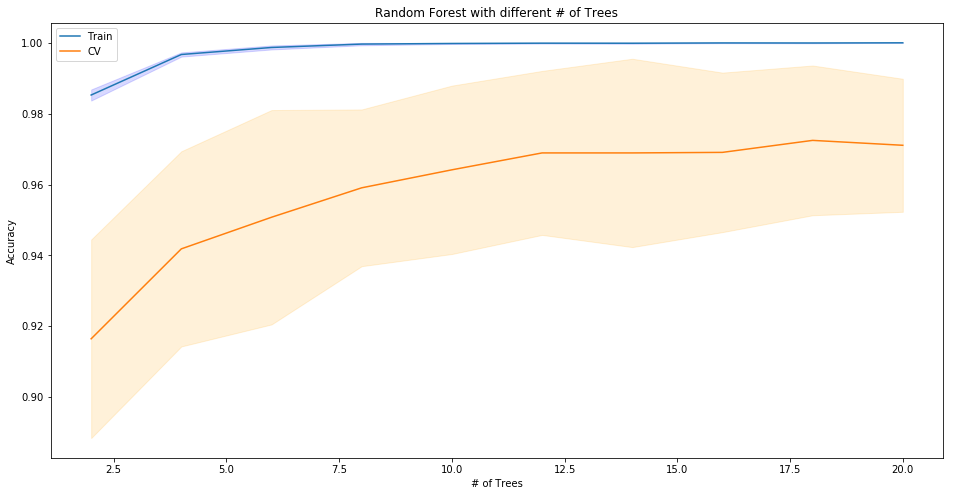

In [75]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(scores[:, 0], scores[:, 1], label='Train')
ax.plot(scores[:, 0], scores[:, 2], label='CV')
ax.fill_between(scores[:, 0],
                 scores[:, 1] + scores[:, 3],
                 scores[:, 1] - scores[:, 3],
                 alpha=0.15, color='blue')
ax.fill_between(scores[:, 0],
                 scores[:, 2] + scores[:, 4],
                 scores[:, 2] - scores[:, 4],
                 alpha=0.15, color='orange')
ax.set_title('Random Forest with different # of Trees'.format(k))
ax.set_ylabel('Accuracy')
ax.set_xlabel('# of Trees')
ax.legend();

Well it's actually worse!

6 - Pick a classification algorithm that has at least two hyperparameters and tune them using `GridSeachCV`.  Comment on your results.

I'm trying logistic regression + PCA tuning number of components and regularization:

In solution he uses random forest tuning n_estimators and max_features!

In [8]:
from sklearn.feature_selection import RFE

So, apparently GridSearchCV gets stuck if I use custom scorers or if I'm multithreading or something like that, so I'm going to try to encode my labels outside the pipeline...

In [9]:
mle = MultiLabelEncoder()
Xtrain_enc = mle.fit_transform(Xtrain)
Xtest_enc = mle.transform(Xtest)

In [13]:
pipe = Pipeline([
    ('sel', RFE(estimator=LogisticRegression())),
    ('lr', LogisticRegression())
])

# C_range = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300]
C_range = [0.01, 0.03, 0.1, 0.3, 1, 3]
comp_range = np.arange(1, 16)
# using grid search to tune regularization and number of PCs
param_grid = [{'sel__n_features_to_select':comp_range, 'lr__C': C_range}]
gs = GridSearchCV(estimator=pipe,
                  param_grid=param_grid,
                  cv=10)
# this could take a very long time...
gs.fit(Xtrain_enc, ytrain)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('sel', RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
  n_f...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'sel__n_features_to_select': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]), 'lr__C': [0.01, 0.03, 0.1, 0.3, 1, 3]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [14]:
print(gs.best_score_)
print(gs.best_params_)

0.954146791814
{'lr__C': 0.3, 'sel__n_features_to_select': 13}


In [16]:
pipe.set_params(sel__n_features_to_select=13, lr__C=0.3)
pipe.fit(Xtrain_enc, ytrain)
pipe.score(Xtest_enc, ytest)

0.95323076923076921

We get 95% accuracy with simple logistic regression, not bad!

### Regression
1 - Head over to the [Machine Learning Repository](http://archive.ics.uci.edu/ml/index.php), download the [Parkinson's Telemonitoring Data Set](http://archive.ics.uci.edu/ml/datasets/Parkinsons+Telemonitoring), and put it into a dataframe.  Be sure to familiarize yourself with the data before proceeding, removing the columns related to time, age, and sex.  We're going to be predicting `motor_UPDRS`, so drop the `total_UPDRS` variable as well.  Break the data into training and testing sets.  Be sure to keep this testing set the same for the duration of this exercise as we will be using to test various algorithms!

In [90]:
parkinson = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/telemonitoring/parkinsons_updrs.data')
parkinson.drop(['age', 'sex', 'test_time', 'total_UPDRS'], axis=1, inplace=True)

In solution he uses dummies for subject#, which I don't think is really "honest".

In [4]:
parkinson.head()

,subject#,motor_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,28.199,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,28.447,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,28.695,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,28.905,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,29.187,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


In [5]:
parkinson.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5875 entries, 0 to 5874
Data columns (total 18 columns):
subject#         5875 non-null int64
motor_UPDRS      5875 non-null float64
Jitter(%)        5875 non-null float64
Jitter(Abs)      5875 non-null float64
Jitter:RAP       5875 non-null float64
Jitter:PPQ5      5875 non-null float64
Jitter:DDP       5875 non-null float64
Shimmer          5875 non-null float64
Shimmer(dB)      5875 non-null float64
Shimmer:APQ3     5875 non-null float64
Shimmer:APQ5     5875 non-null float64
Shimmer:APQ11    5875 non-null float64
Shimmer:DDA      5875 non-null float64
NHR              5875 non-null float64
HNR              5875 non-null float64
RPDE             5875 non-null float64
DFA              5875 non-null float64
PPE              5875 non-null float64
dtypes: float64(17), int64(1)
memory usage: 826.2 KB


In [6]:
parkinson.describe().T

,count,mean,std,min,25%,50%,75%,max
subject#,5875.0,21.494128,12.372279,1.000000,10.000000,22.000000,33.000000,42.000000
motor_UPDRS,5875.0,21.296229,8.129282,5.037700,15.000000,20.871000,27.596500,39.511000
Jitter(%),5875.0,0.006154,0.005624,0.000830,0.003580,0.004900,0.006800,0.099990
Jitter(Abs),5875.0,0.000044,0.000036,0.000002,0.000022,0.000035,0.000053,0.000446
Jitter:RAP,5875.0,0.002987,0.003124,0.000330,0.001580,0.002250,0.003290,0.057540
Jitter:PPQ5,5875.0,0.003277,0.003732,0.000430,0.001820,0.002490,0.003460,0.069560
Jitter:DDP,5875.0,0.008962,0.009371,0.000980,0.004730,0.006750,0.009870,0.172630
Shimmer,5875.0,0.034035,0.025835,0.003060,0.019120,0.027510,0.039750,0.268630
Shimmer(dB),5875.0,0.310960,0.230254,0.026000,0.175000,0.253000,0.365000,2.107000
Shimmer:APQ3,5875.0,0.017156,0.013237,0.001610,0.009280,0.013700,0.020575,0.162670


In [91]:
# I'm dropping subject# because it is the patient id
Xtrain, Xtest, ytrain, ytest = train_test_split(parkinson.drop(['subject#', 'motor_UPDRS'], axis=1),
                                                parkinson.motor_UPDRS,
                                                test_size=0.2,
                                                random_state=54)

2 - Fit a machine learning algorithm of your choice to the data, tuning hyperparameters using the Better Holdout Method. Generate training and validation plots and comment on your results.

In [92]:
# scaling and ridge regression
pipe = Pipeline([
    ('stsc', StandardScaler()),
    ('ridge', Ridge())
])

In [93]:
# better hold out
Xtr, Xcv, ytr, ycv = train_test_split(Xtrain, ytrain, test_size=0.2, random_state=42)
scores = []
# looping through regularization values
for a in [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000, 3000]:
    pipe.set_params(ridge__alpha=a)
    pipe.fit(Xtr, ytr)
    tr_score = pipe.score(Xtr, ytr)
    cv_score = pipe.score(Xcv, ycv)
    scores.append([a, tr_score, cv_score])

scores = np.array(scores)

In [94]:
scores

array([[  1.00000000e-03,   1.16318220e-01,   7.79041095e-02],
       [  3.00000000e-03,   1.16275461e-01,   7.78532625e-02],
       [  1.00000000e-02,   1.16236154e-01,   7.78025200e-02],
       [  3.00000000e-02,   1.16218763e-01,   7.77831332e-02],
       [  1.00000000e-01,   1.16211646e-01,   7.77870354e-02],
       [  3.00000000e-01,   1.16209196e-01,   7.78218305e-02],
       [  1.00000000e+00,   1.16205051e-01,   7.79468802e-02],
       [  3.00000000e+00,   1.16179855e-01,   7.82654107e-02],
       [  1.00000000e+01,   1.16004991e-01,   7.90742483e-02],
       [  3.00000000e+01,   1.15389966e-01,   8.03377924e-02],
       [  1.00000000e+02,   1.13505951e-01,   8.20404736e-02],
       [  3.00000000e+02,   1.08208849e-01,   8.20675091e-02],
       [  1.00000000e+03,   9.12025646e-02,   7.33942476e-02],
       [  3.00000000e+03,   6.45159818e-02,   5.52072122e-02]])

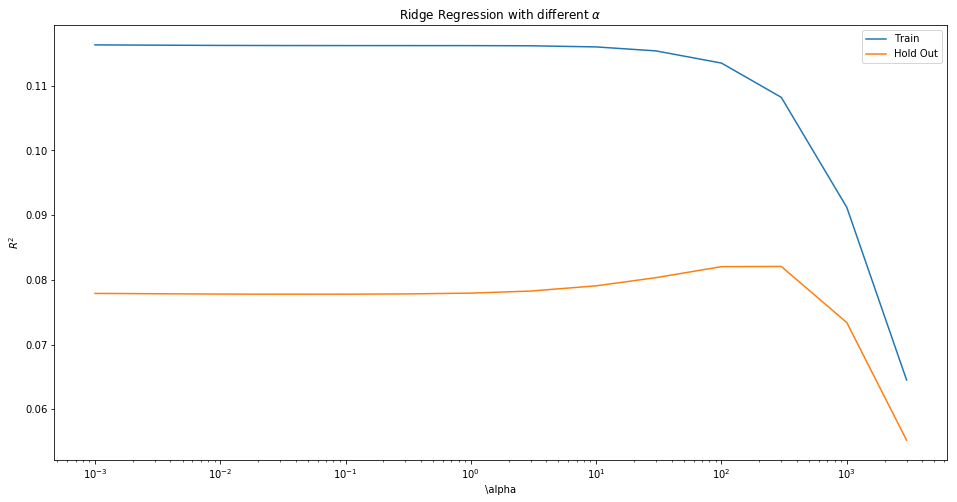

In [95]:
fig, ax = plt.subplots(figsize=(16, 8), subplot_kw=dict(xscale='log'))

ax.plot(scores[:, 0], scores[:, 1], label='Train')
ax.plot(scores[:, 0], scores[:, 2], label='Hold Out')
ax.set_title(r'Ridge Regression with different $\alpha$')
ax.set_ylabel('$R^2$')
ax.set_xlabel(r'\alpha')
ax.legend();

These doesn't seems so randomly scattered...

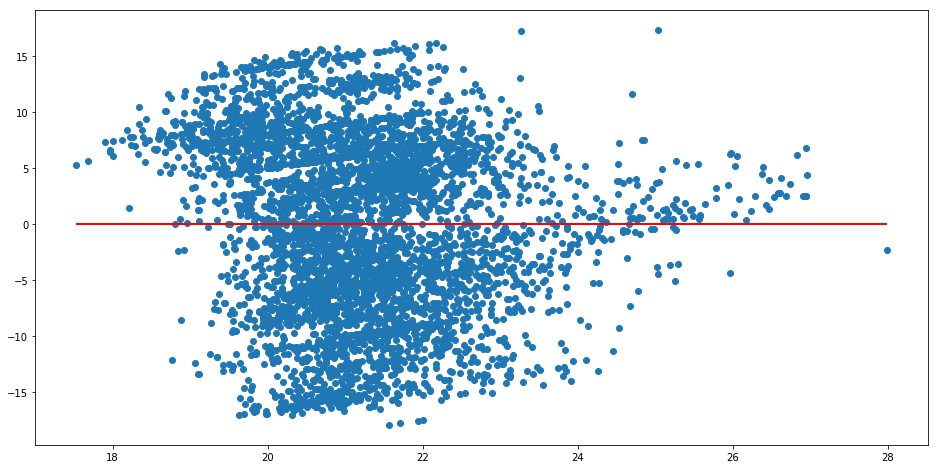

In [97]:
ypred = pipe.predict(Xtrain)
residuals = ypred - ytrain
plt.figure(figsize=(16, 8))
plt.scatter(ypred, residuals)
plt.hlines(y=0, xmin=ypred.min(), xmax=ypred.max(), lw=2, color='red');

In [98]:
pipe.set_params(ridge__alpha=100)
pipe.fit(Xtrain, ytrain)
pipe.score(Xtest, ytest)

0.091677187638304902

The score is very bad, the best choice for the regularization parameter seems to be 100 but there seems to be a problem of serious bias in this dataset. We may need more features to get accurate predictions.

3 - Repeat part (2), this time using cross validation.  Comment on your results.

Again in the solution he uses cross_validation_curve...

In [14]:
scores = []

for a in [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000, 3000]:
    kfold = KFold(n_splits=10, random_state=1).split(Xtrain, ytrain)
    fold_scores = []
    pipe.set_params(ridge__alpha=a)
    print('alpha = {}'.format(a))
    for i, (train, test) in enumerate(kfold):
        Xtr, ytr = Xtrain.iloc[train, :], ytrain.iloc[train]
        Xcv, ycv = Xtrain.iloc[test, :], ytrain.iloc[test]
        pipe.fit(Xtr, ytr)
        tr_score = pipe.score(Xtr, ytr)
        cv_score = pipe.score(Xcv, ycv)
        fold_scores.append([i, tr_score, cv_score])
        print('Fold {} done'.format(i+1))

    fold_scores = np.array(fold_scores)
    scores.append([a, fold_scores.mean(axis=0)[1], fold_scores.mean(axis=0)[2],
                   fold_scores.std(axis=0)[1], fold_scores.std(axis=0)[2]])

scores = np.array(scores)

alpha = 0.001
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
alpha = 0.003
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
alpha = 0.01
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
alpha = 0.03
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
alpha = 0.1
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
alpha = 0.3
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
alpha = 1
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
alpha = 3
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 

In [15]:
scores

array([[  1.00000000e-03,   1.10647735e-01,   9.74801567e-02,
          2.68480397e-03,   2.67480515e-02],
       [  3.00000000e-03,   1.10596127e-01,   9.75220009e-02,
          2.67857362e-03,   2.67084848e-02],
       [  1.00000000e-02,   1.10541942e-01,   9.75317132e-02,
          2.67243942e-03,   2.66857620e-02],
       [  3.00000000e-02,   1.10516140e-01,   9.75337815e-02,
          2.66940417e-03,   2.66721342e-02],
       [  1.00000000e-01,   1.10505295e-01,   9.75440898e-02,
          2.66809593e-03,   2.66462125e-02],
       [  3.00000000e-01,   1.10501756e-01,   9.75760533e-02,
          2.66761795e-03,   2.65795742e-02],
       [  1.00000000e+00,   1.10497960e-01,   9.76838590e-02,
          2.66663807e-03,   2.63583311e-02],
       [  3.00000000e+00,   1.10478219e-01,   9.79528837e-02,
          2.66059827e-03,   2.57977963e-02],
       [  1.00000000e+01,   1.10340899e-01,   9.86046213e-02,
          2.62209515e-03,   2.43741017e-02],
       [  3.00000000e+01,   1.0984721

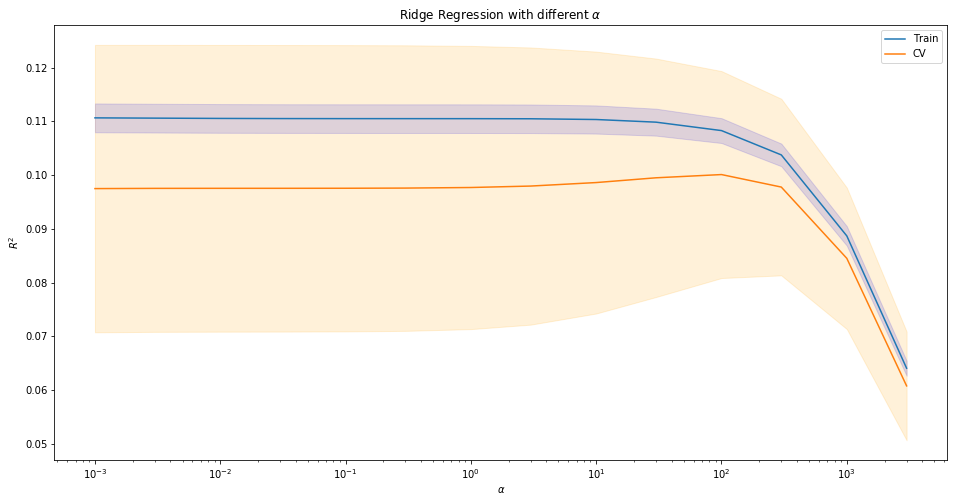

In [16]:
fig, ax = plt.subplots(figsize=(16, 8), subplot_kw=dict(xscale='log'))

ax.plot(scores[:, 0], scores[:, 1], label='Train')
ax.plot(scores[:, 0], scores[:, 2], label='CV')
ax.fill_between(scores[:, 0],
                 scores[:, 1] + scores[:, 3],
                 scores[:, 1] - scores[:, 3],
                 alpha=0.15, color='blue')
ax.fill_between(scores[:, 0],
                 scores[:, 2] + scores[:, 4],
                 scores[:, 2] - scores[:, 4],
                 alpha=0.15, color='orange')
ax.set_title(r'Ridge Regression with different $\alpha$')
ax.set_ylabel('$R^2$')
ax.set_xlabel(r'$\alpha$')
ax.legend();

The two curves are even closer, but again performances are overall very poor. This plot confirms that we have a high bias for this dataset.

4 - Repeat part (3) using a different machine learning algorithm.  Comment on your results.

In [104]:
# scaling and random forest
pipe = Pipeline([
    ('scl', StandardScaler()),
    ('forest', RandomForestRegressor())
])

In [105]:
scores = []
# looping through different number of trees
for n in [3, 10, 30, 100, 300]:
    kfold = KFold(n_splits=10, random_state=1).split(Xtrain, ytrain)
    fold_scores = []
    pipe.set_params(forest__n_estimators=n)
    print('# trees = {}'.format(n))
    # looping through folds
    for i, (train, test) in enumerate(kfold):
        Xtr, ytr = Xtrain.iloc[train, :], ytrain.iloc[train]
        Xcv, ycv = Xtrain.iloc[test, :], ytrain.iloc[test]
        pipe.fit(Xtr, ytr)
        tr_score = pipe.score(Xtr, ytr)
        cv_score = pipe.score(Xcv, ycv)
        fold_scores.append([i, tr_score, cv_score])
        print('Fold {} done'.format(i+1))

    fold_scores = np.array(fold_scores)
    scores.append([n, fold_scores.mean(axis=0)[1], fold_scores.mean(axis=0)[2],
                   fold_scores.std(axis=0)[1], fold_scores.std(axis=0)[2]])

scores = np.array(scores)

# trees = 3
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
# trees = 10
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
# trees = 30
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
# trees = 100
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
# trees = 300
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done


In [106]:
scores

array([[  3.00000000e+00,   7.75759563e-01,   1.11207568e-01,
          6.20566798e-03,   9.25870932e-02],
       [  1.00000000e+01,   8.73927468e-01,   3.04753759e-01,
          3.50032359e-03,   5.00045767e-02],
       [  3.00000000e+01,   9.02512362e-01,   3.44222628e-01,
          1.40166596e-03,   4.45500648e-02],
       [  1.00000000e+02,   9.11940634e-01,   3.61549622e-01,
          1.40964680e-03,   3.39684626e-02],
       [  3.00000000e+02,   9.14474654e-01,   3.66088495e-01,
          1.15033779e-03,   3.40254413e-02]])

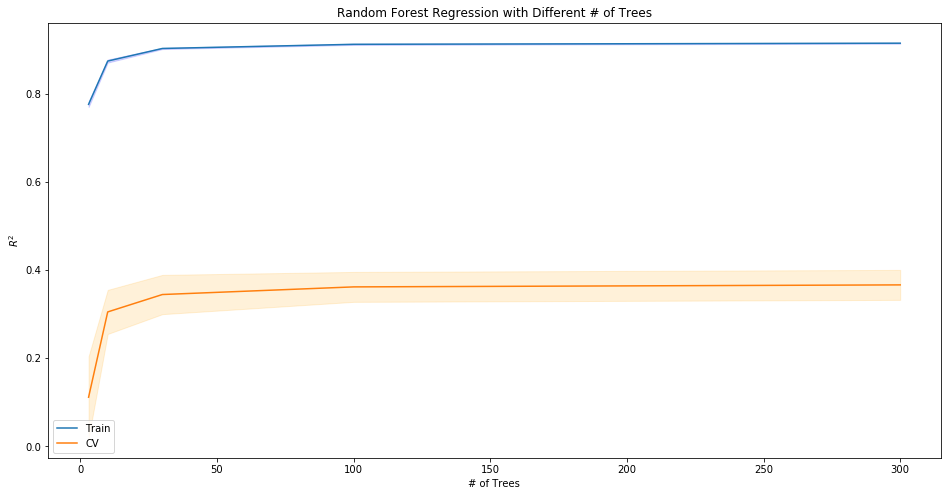

In [107]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(scores[:, 0], scores[:, 1], label='Train')
ax.plot(scores[:, 0], scores[:, 2], label='CV')
ax.fill_between(scores[:, 0],
                 scores[:, 1] + scores[:, 3],
                 scores[:, 1] - scores[:, 3],
                 alpha=0.15, color='blue')
ax.fill_between(scores[:, 0],
                 scores[:, 2] + scores[:, 4],
                 scores[:, 2] - scores[:, 4],
                 alpha=0.15, color='orange')
ax.set_title('Random Forest Regression with Different # of Trees')
ax.set_ylabel('$R^2$')
ax.set_xlabel('# of Trees')
ax.legend();

In [108]:
pipe.set_params(forest__n_estimators=100)
pipe.fit(Xtrain, ytrain)
pipe.score(Xtest, ytest)

0.32650193384436466

Using a random forest we get better performances but we have a serious problem of high variance in this case.

5 - Which ever of your two algorithms in parts (3) and (4) performed more poorly, perform a variable selection to see if you can improve your results.

I'm going to use PCA to try and improve the R regression, but I don't think there is much to do...

In solution he uses LassoCV with SelectFromModel:

In [101]:
scl = StandardScaler()
sfm = SelectFromModel(LassoCV())
Xtrain_sc = scl.fit_transform(Xtrain)
Xtest_sc = scl.transform(Xtest)
Xtrain_lm = sfm.fit_transform(Xtrain_sc, ytrain)
Xtest_lm = sfm.transform(Xtest_sc)

train_scores, test_scores = validation_curve(Ridge(), Xtrain_lm, ytrain,
                                             param_name='alpha',
                                             param_range=[0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000, 3000])

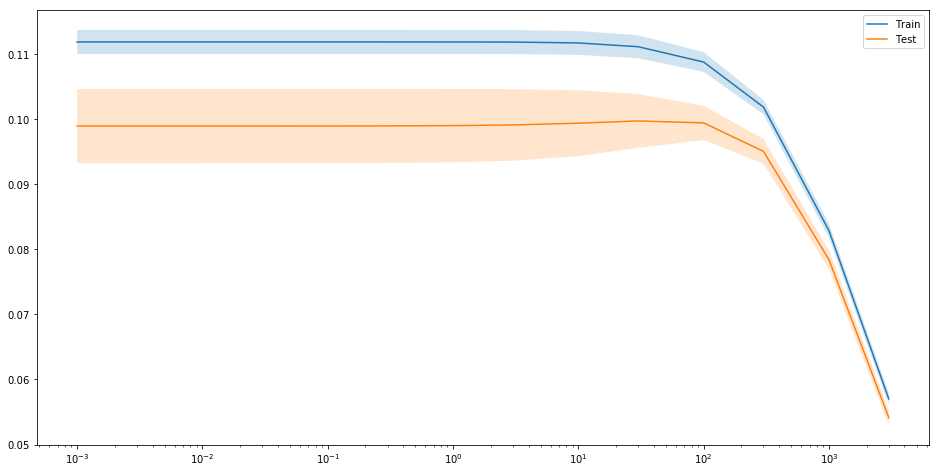

In [103]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig, ax = plt.subplots(figsize=(16, 8), subplot_kw=dict(xscale='log'))

ax.plot([0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000, 3000],
        train_scores_mean, label='Train')
ax.fill_between([0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000, 3000],
                train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
ax.plot([0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000, 3000],
        test_scores_mean, label='Test')
ax.fill_between([0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000, 3000],
                test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2)
ax.legend();

In [21]:
pca = PCA()
pca.fit(Xtrain)
pca.explained_variance_ratio_

array([  9.98053787e-01,   1.13952768e-03,   3.14424702e-04,
         2.75678723e-04,   1.45276689e-04,   6.06695114e-05,
         5.65762585e-06,   2.43417414e-06,   1.91760025e-06,
         3.76194769e-07,   1.95582169e-07,   3.85328969e-08,
         1.59326323e-08,   1.08253999e-11,   3.56549469e-13,
         3.45293868e-13])

I guess we can try with 12 components

In [22]:
pipe = Pipeline([
    ('scl', StandardScaler()),
    ('pca', PCA(n_components=12)),
    ('ridge', Ridge())
])

In [23]:
scores = []

for a in [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000, 3000]:
    kfold = KFold(n_splits=10, random_state=1).split(Xtrain, ytrain)
    fold_scores = []
    pipe.set_params(ridge__alpha=a)
    print('alpha = {}'.format(a))
    for i, (train, test) in enumerate(kfold):
        Xtr, ytr = Xtrain.iloc[train, :], ytrain.iloc[train]
        Xcv, ycv = Xtrain.iloc[test, :], ytrain.iloc[test]
        pipe.fit(Xtr, ytr)
        
        tr_score = pipe.score(Xtr, ytr)
        cv_score = pipe.score(Xcv, ycv)
        fold_scores.append([i, tr_score, cv_score])
        print('Fold {} done'.format(i+1))

    fold_scores = np.array(fold_scores)
    scores.append([a, fold_scores.mean(axis=0)[1], fold_scores.mean(axis=0)[2],
                   fold_scores.std(axis=0)[1], fold_scores.std(axis=0)[2]])

scores = np.array(scores)

alpha = 0.001
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
alpha = 0.003
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
alpha = 0.01
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
alpha = 0.03
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
alpha = 0.1
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
alpha = 0.3
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
alpha = 1
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
alpha = 3
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 

In [24]:
scores

array([[  1.00000000e-03,   1.09179570e-01,   9.88752483e-02,
          2.21892150e-03,   2.12792494e-02],
       [  3.00000000e-03,   1.09179570e-01,   9.88753444e-02,
          2.21892150e-03,   2.12791443e-02],
       [  1.00000000e-02,   1.09179570e-01,   9.88756809e-02,
          2.21892150e-03,   2.12787766e-02],
       [  3.00000000e-02,   1.09179569e-01,   9.88766415e-02,
          2.21892148e-03,   2.12777263e-02],
       [  1.00000000e-01,   1.09179565e-01,   9.88799978e-02,
          2.21892126e-03,   2.12740539e-02],
       [  3.00000000e-01,   1.09179528e-01,   9.88895342e-02,
          2.21891930e-03,   2.12635927e-02],
       [  1.00000000e+00,   1.09179116e-01,   9.89223077e-02,
          2.21889739e-03,   2.12273368e-02],
       [  3.00000000e+00,   1.09175672e-01,   9.90110431e-02,
          2.21871233e-03,   2.11266791e-02],
       [  1.00000000e+01,   1.09142253e-01,   9.92733225e-02,
          2.21687510e-03,   2.08039042e-02],
       [  3.00000000e+01,   1.0893944

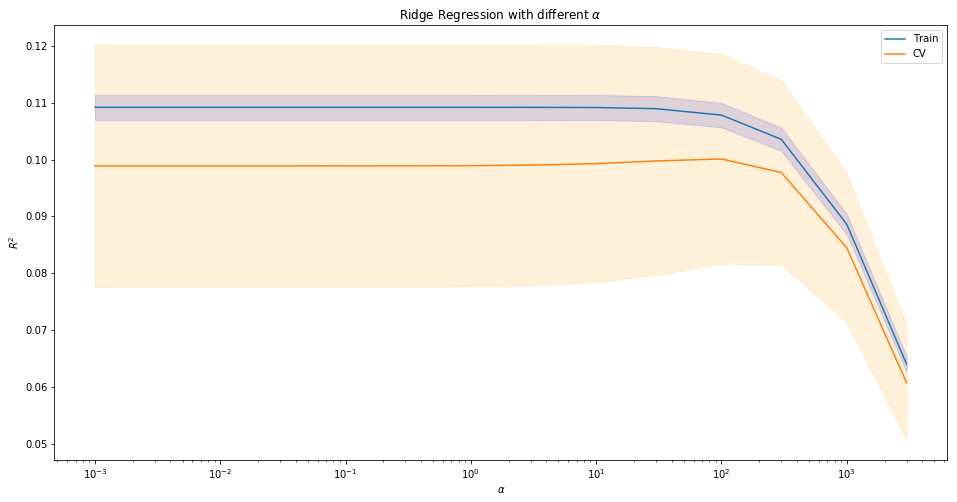

In [25]:
fig, ax = plt.subplots(figsize=(16, 8), subplot_kw=dict(xscale='log'))

ax.plot(scores[:, 0], scores[:, 1], label='Train')
ax.plot(scores[:, 0], scores[:, 2], label='CV')
ax.fill_between(scores[:, 0],
                 scores[:, 1] + scores[:, 3],
                 scores[:, 1] - scores[:, 3],
                 alpha=0.15, color='blue')
ax.fill_between(scores[:, 0],
                 scores[:, 2] + scores[:, 4],
                 scores[:, 2] - scores[:, 4],
                 alpha=0.15, color='orange')
ax.set_title(r'Ridge Regression with different $\alpha$')
ax.set_ylabel('$R^2$')
ax.set_xlabel(r'$\alpha$')
ax.legend();

Not much of an improvement...

6 - Pick a regression algorithm that has at least two hyperparameters and tune them using `GridSeachCV`.  Comment on your results.

I'm going to try and add some polynomial features to the Ridge regression to see if it can perform better:

In [44]:
pipe = Pipeline([
    ('scl', StandardScaler()),
    ('pca', PCA(n_components=9)),
    ('poly', PolynomialFeatures()),
    ('ridge', Ridge())
])

alpha_range = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
degree_range = np.arange(1, 4)
# using grid search to tune regularization and degree of polynomials
param_grid = [{'poly__degree':degree_range, 'ridge__alpha': alpha_range}]
gs = GridSearchCV(estimator=pipe,
                  param_grid=param_grid,
                  cv=10,
                  n_jobs=2)

gs.fit(Xtrain, ytrain)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=9, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=2,
       param_grid=[{'poly__degree': array([1, 2, 3]), 'ridge__alpha': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [46]:
print(gs.best_score_)
print(gs.best_params_)

0.184314178869
{'poly__degree': 2, 'ridge__alpha': 30}


In [47]:
pipe.set_params(poly__degree=2, ridge__alpha=30)
pipe.fit(Xtrain, ytrain)
pipe.score(Xtest, ytest)

0.18657109593637167

We have a slight improvement introducing polynomial features, but the score is still very low...

In solutions using random forest and tuning n_estimators and max_features he gets 0.357.